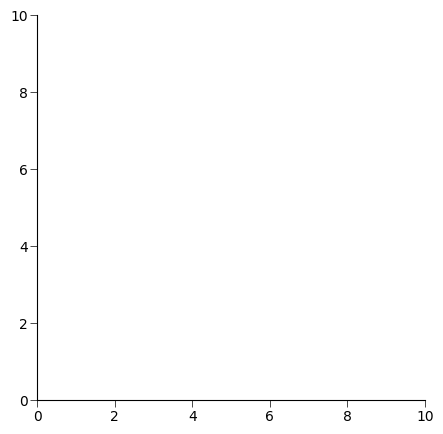

In [1]:
import scanpy as sc
import numpy as np
import operator
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import os
#setPltLinewidth(0)
# os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,6,7"

from torch.nn import DataParallel
import os
import anndata as ad
import cospar as cs
import scanpy as sc
def createFig(figsize=(8, 4)):
    fig,ax=plt.subplots()           
    ax.spines['right'].set_color('none')     
    ax.spines['top'].set_color('none')
    #ax.spines['bottom'].set_color('none')     
    #ax.spines['left'].set_color('none')
    for line in ax.yaxis.get_ticklines():
        line.set_markersize(5)
        line.set_color("#585958")
        line.set_markeredgewidth(0.5)
    for line in ax.xaxis.get_ticklines():
        line.set_markersize(5)
        line.set_markeredgewidth(0.5)
        line.set_color("#585958")
    ax.set_xbound(0,10)
    ax.set_ybound(0,10)
    fig.set_size_inches(figsize)
    return fig,ax
def setPltLinewidth(linewidth:float):
    mpl.rcParams['axes.linewidth'] = linewidth
import matplotlib as mpl
fig,ax=createFig()
fig.set_size_inches(5,5)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
setPltLinewidth(1)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1


In [24]:
adata=cs.hf.read("/home/zhengtuo/songtao/pei_HSC_preference.h5ad")
#adata.obs['index']=range(adata.shape[0])


In [30]:
adata

AnnData object with n_obs × n_vars = 23808 × 24507
    obs: 'sample_name', 'CI', 'max.barcode', 'type', 'leiden', 'cell_type', 'batch_name', 'fate_bias', 'index', 'HSC_preference'
    uns: 'batch_name_colors', 'cell_type_colors', 'fate_bias_colors', 'leiden', 'leiden_colors', 'neighbors', 'rank_genes_groups', 'sample_name_colors'
    obsm: 'X_pca', 'X_scanorama', 'X_umap'
    obsp: 'connectivities', 'distances'

In [3]:
traincell1=np.loadtxt('/home/zhengtuo/songtao/3traincell1.txt')
traincell2=np.loadtxt('/home/zhengtuo/songtao/3traincell2.txt')
testcell1=np.loadtxt('/home/zhengtuo/songtao/3testcell1.txt')
testcell2=np.loadtxt('/home/zhengtuo/songtao/3testcell2.txt')
train_rel=np.loadtxt('/home/zhengtuo/songtao/3trainrel.txt',dtype=int)
test_rel=np.loadtxt('/home/zhengtuo/songtao/3testrel.txt',dtype=int)
dic_train={}
dic_test={}
for i in train_rel:  
    dic_train[i] = dic_train.get(i, 0) + 1
print(dic_train)
for i in test_rel:  
    dic_test[i] = dic_test.get(i, 0) + 1
print(dic_test)

{1: 3418, 0: 6345, 2: 2385}
{0: 9, 2: 15}


In [12]:
from math import sqrt

import torch
import torch.nn as nn
num_relations=3
len_geneExp=24507
len_embedding=256
learning_rate=0.0001
num_epoch=10
batchsize=512
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.LeakyReLU(inplace=False),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        #print('channel:',c)
        #print('size:',x.shape)
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        #print('y_size:',y.shape)
        return x * y.expand_as(x)
class MutiheadAttention(nn.Module):
    def __init__(self, input_dim, dim_k, dim_v,num_heads):
        super(MutiheadAttention, self).__init__()
        self.dim_q = dim_k # 一般默认 Q=K
        self.dim_k = dim_k
        self.dim_v = dim_v
        self.num_units=dim_k
        self.num_heads=num_heads
        #定义线性变换函数
        self.linear_q = nn.Linear(input_dim, dim_k, bias=False)
        self.linear_k = nn.Linear(input_dim, dim_k, bias=False)
        self.linear_v = nn.Linear(input_dim, dim_v, bias=False)
        self._norm_fact = 1 / sqrt(dim_k)

    def forward(self, x):
        # x: batch_size, seq_len, input_dim
        q = self.linear_q(x)  # batch_size, seq_len, dim_k
        k = self.linear_k(x)  # batch_size, seq_len, dim_k
        v = self.linear_v(x)  # batch_size, seq_len, dim_v
        split_size = self.num_units // self.num_heads
        q = torch.stack(torch.split(q, split_size, dim=2), dim=0)  # [h, N, T_q, num_units/h]
        k = torch.stack(torch.split(k, split_size, dim=2), dim=0)  # [h, N, T_k, num_units/h]
        v = torch.stack(torch.split(v, split_size, dim=2), dim=0)  # [h, N, T_k, num_units/h]

        scores = torch.matmul(q, k.transpose(2, 3))
        scores = scores / (self.dim_k ** 0.5)
        
        scores = F.softmax(scores, dim=3)
        ## out = score * V
        out = torch.matmul(scores, v)  # [h, N, T_q, num_units/h]
        out = torch.cat(torch.split(out, 1, dim=0), dim=3).squeeze(0) 

        return out

class ResidualBlock(torch.nn.Module):
    def __init__(self,channels):
        super(ResidualBlock,self).__init__()
        self.channels = channels
        
        self.conv1 = nn.Conv1d(channels,channels,kernel_size=3,padding=1)
        self.conv2 = nn.Conv1d(channels,channels,kernel_size=3,padding=1)
        self.se=SELayer(channels,16)
    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.conv2(y)
        y=self.se(y)
        return F.relu(x+y)

class model(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.att=MutiheadAttention(len_embedding*2,512,512,64)
        self.layernorm=nn.LayerNorm(512)
        self.conv1 = nn.Conv1d(1, 32, 4)  # 输入通道数为1，输出通道数为6
        self.relu1=nn.LeakyReLU(0.2, inplace=True)
        self.rblock1 = ResidualBlock(32)
        self.conv2 = nn.Conv1d(32,64, 4)  # 输入通道数为6，输出通道数为16
        self.batchn1=nn.BatchNorm1d(64)
        self.relu2= nn.LeakyReLU(0.2, inplace=True)
        self.rblock2 = ResidualBlock(64)
        self.conv3=nn.Conv1d(64,128,4)
        self.batchn2=nn.BatchNorm1d(128)
        self.relu3= nn.LeakyReLU(0.2, inplace=True)
        self.rblock3 = ResidualBlock(128)
        self.conv4=nn.Conv1d(128,256,4)
        self.batchn3=nn.BatchNorm1d(256)
        self.relu4= nn.LeakyReLU(0.2, inplace=True)
        self.rblock4 = ResidualBlock(256)
        self.dropout=nn.Dropout()
        self.fc1 = nn.Linear(7424, num_relations)
        
    def forward(self, x):
        # 输入x -> conv1 -> relu -> 2x2窗口的最大池化
        x=self.att(x)+x
        x=self.layernorm(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock1(x)
        # # 输入x -> conv2 -> relu -> 2x2窗口的最大池化
        x = self.conv2(x)
        x=self.batchn1(x)
        x=self.relu2(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock2(x)
        
        x = self.conv3(x)
        x=self.batchn2(x)
        x=self.relu3(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock3(x)
        
        x = self.conv4(x)
        x=self.batchn3(x)
        x=self.relu4(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock4(x)
        # # view函数将张量x变形成一维向量形式，总特征数不变，为全连接层做准备
        x = x.view(x.size()[0], -1)
        x=self.dropout(x)
        x=self.fc1(x)
        return x
geneEnc=nn.Sequential(
    #nn.Dropout(),
    nn.Linear(len_geneExp, len_embedding),
#     nn.ReLU(),
#             nn.Linear(100, 100),
#             nn.ReLU(),
#      nn.Linear(100, 100),
#             nn.ReLU(),
#     nn.Linear(100, 100),
#             nn.ReLU(),
#     nn.Linear(100, len_embedding),
)
geneDec = nn.Sequential(
    nn.Linear(len_embedding, 512),
    nn.Linear(512, len_geneExp),

)
genemap = nn.Sequential(
    # nn.Dropout(),
     nn.Linear(len_embedding, 100),
     nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
   nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
   nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, len_embedding),

)


model=model()
device = torch.device("cuda:7")
device2 = torch.device("cuda:7")
path='/home/zhengtuo/songtao/pei.pth'
pretrained_weights = torch.load(path)
model.load_state_dict(pretrained_weights['model'])
geneEnc.load_state_dict(pretrained_weights['geneEnc'])
genemap.load_state_dict(pretrained_weights['genemap'])
#geneDec.load_state_dict(pretrained_weights['geneDec'])

model.to(device2)
geneEnc.to(device2)
#geneDec.to(device2)
genemap.to(device2)


genemap.eval()
model.eval()
geneEnc.eval()
#geneDec.eval()


Sequential(
  (0): Linear(in_features=24507, out_features=256, bias=True)
)

In [5]:
adata2=cs.hf.read("/home/zhengtuo/songtao/pei_hscerymo2.h5ad")
adata2

AnnData object with n_obs × n_vars = 1366 × 24507
    obs: 'sample_name', 'CI', 'max.barcode', 'type', 'leiden', 'cell_type', 'batch_name', 'fate_bias', 'index', 'HSC_preference'
    uns: 'batch_name_colors', 'cell_type_colors', 'fate_bias_colors', 'leiden', 'leiden_colors', 'neighbors', 'rank_genes_groups', 'sample_name_colors'
    obsm: 'X_pca', 'X_scanorama', 'X_umap'
    obsp: 'connectivities', 'distances'

In [13]:

Embeddings_path = '/home/zhengtuo/songtao/dynamic2.txt.npz' # txt dir to save cell embeddings
from tqdm import trange
geneEnc.to(device2)
all_embeddings = []
with torch.no_grad():
    for i in trange(adata2.shape[0]):
        x = 1*adata2.X[i].toarray()
        geneExp = torch.tensor(x).to(device2)
        geneExp=torch.reshape(geneExp,(1,24507))
        geneExp = geneExp.to(torch.float32)
        geneEmbedding = geneEnc(geneExp)
        geneEmbedding = geneEmbedding.cpu().detach().numpy() # or any other data type
        all_embeddings.append(geneEmbedding)
    np.savez(Embeddings_path,all_embeddings)
mapembedding = []
with torch.no_grad():
    for i in trange(adata2.shape[0]):
        x = 1*adata2.X[i].toarray()
        geneExp = torch.tensor(x).to(device2)
        geneExp = geneExp.to(torch.float32)
        geneEmbedding = geneEnc(geneExp)
        geneEmbedding=genemap(geneEmbedding)
        geneEmbedding = geneEmbedding.cpu().detach().numpy() # or any other data type
        mapembedding.append(geneEmbedding)
all_embeddings=np.array(all_embeddings)
mapembedding=np.array(mapembedding)
adata2.obsm['geneEnc']=all_embeddings
adata2.obsm['genemap']=mapembedding
#adata2.obsm['X_pca']=adata2.obsm['X_pca'].cpu().numpy()

        
    
    

100%|█████████████████████████████████████| 1366/1366 [00:01<00:00, 1221.62it/s]


/home/zhengtuo/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


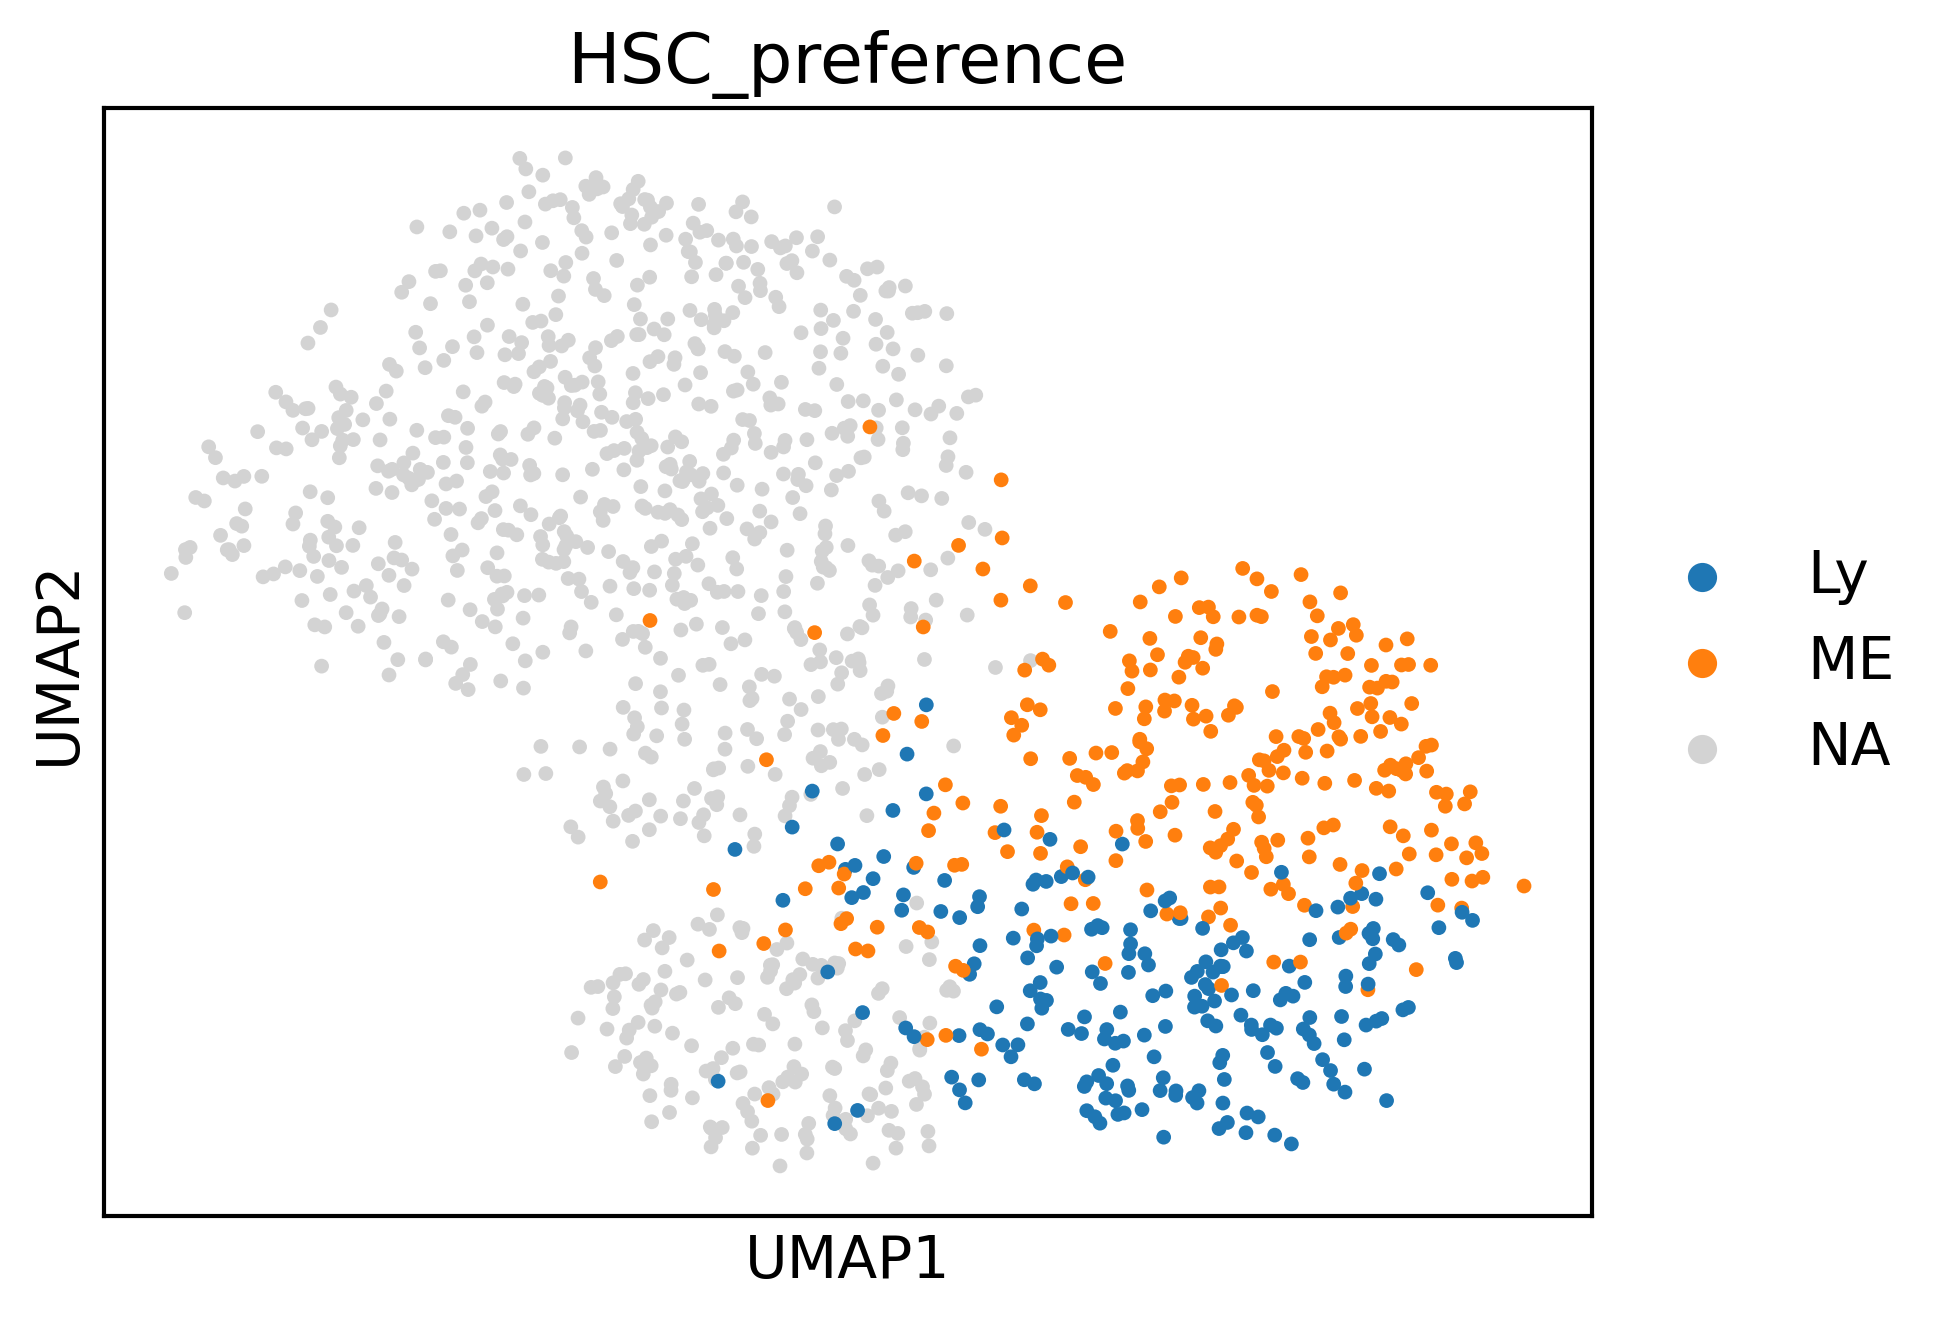

In [16]:
n= np.load( '/home/zhengtuo/songtao/dynamic2.txt.npz')
n=torch.tensor(n['arr_0'])
n=torch.reshape(n,(1366,256))
adata2.obsm["X_pca"] = n
cs.pp.get_X_emb(adata2, n_neighbors=20, umap_min_dist=2)
# cs.pl.embedding(adata2, color="deep")
sc.pl.umap(adata2, color="HSC_preference", s=50)


In [17]:
def compute_velocity_on_grid(
    X_emb,
    M_emb,
    density=None,
    smooth=None,
    n_neighbors=None,
    min_mass=None,
    autoscale=True,
    adjust_for_stream=False,
    cutoff_perc=None,
):
    # remove invalid cells
    idx_valid = np.isfinite(X_emb.sum(1) + M_emb.sum(1))
    X_emb = X_emb[idx_valid]
    M_emb = M_emb[idx_valid]

    # prepare grid
    n_obs, n_dim = X_emb.shape
    density = 0.5 if density is None else density
    smooth = 0.5 if smooth is None else smooth

    grs = []
    for dim_i in range(n_dim):
        m, M = np.min(X_emb[:, dim_i]), np.max(X_emb[:, dim_i])
        m = m - 0.01 * np.abs(M - m)
        M = M + 0.01 * np.abs(M - m)
        gr = np.linspace(m, M, int(50 * density))
        grs.append(gr)

    meshes_tuple = np.meshgrid(*grs)
    X_grid = np.vstack([i.flat for i in meshes_tuple]).T

    # estimate grid velocities
    if n_neighbors is None:
        n_neighbors = int(n_obs / 50)
    nn = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
    nn.fit(X_emb)
    dists, neighs = nn.kneighbors(X_grid)

    scale = np.mean([(g[1] - g[0]) for g in grs]) * smooth
    weight = normal.pdf(x=dists, scale=scale)
    p_mass = weight.sum(1)

    V_grid = (M_emb[neighs] * weight[:, :, None]).sum(1)
    V_grid /= np.maximum(1, p_mass)[:, None]
    if min_mass is None:
        min_mass = 1

    if adjust_for_stream:
        X_grid = np.stack([np.unique(X_grid[:, 0]), np.unique(X_grid[:, 1])])
        ns = int(np.sqrt(len(V_grid[:, 0])))
        V_grid = V_grid.T.reshape(2, ns, ns)

        mass = np.sqrt((V_grid ** 2).sum(0))
        min_mass = 10 ** (min_mass - 6)  # default min_mass = 1e-5
        min_mass = np.clip(min_mass, None, np.max(mass) * 0.9)
        cutoff = mass.reshape(V_grid[0].shape) < min_mass

        if cutoff_perc is None:
            cutoff_perc = 5
        length = np.sum(np.mean(np.abs(M_emb[neighs]), axis=1), axis=1).T
        length = length.reshape(ns, ns)
        cutoff |= length < np.percentile(length, cutoff_perc)

        V_grid[0][cutoff] = np.nan
    else:
        min_mass *= np.percentile(p_mass, 99) / 100
        X_grid, V_grid = X_grid[p_mass > min_mass], V_grid[p_mass > min_mass]

        if autoscale:
            V_grid /= 3 * quiver_autoscale(X_grid, V_grid)

    return X_grid, V_grid

def quiver_autoscale(X_emb, V_emb):
    import matplotlib.pyplot as pl

    scale_factor = np.abs(X_emb).max()  # just so that it handles very large values
    fig, ax = pl.subplots()
    Q = ax.quiver(
        X_emb[:, 0] / scale_factor,
        X_emb[:, 1] / scale_factor,
        V_emb[:, 0],
        V_emb[:, 1],
        angles="xy",
        scale_units="xy",
        scale=None,
    )
    Q._init()
    fig.clf()
    pl.close(fig)
    return Q.scale / scale_factor


100%|██████████████████████████████████████| 1366/1366 [00:02<00:00, 597.23it/s]


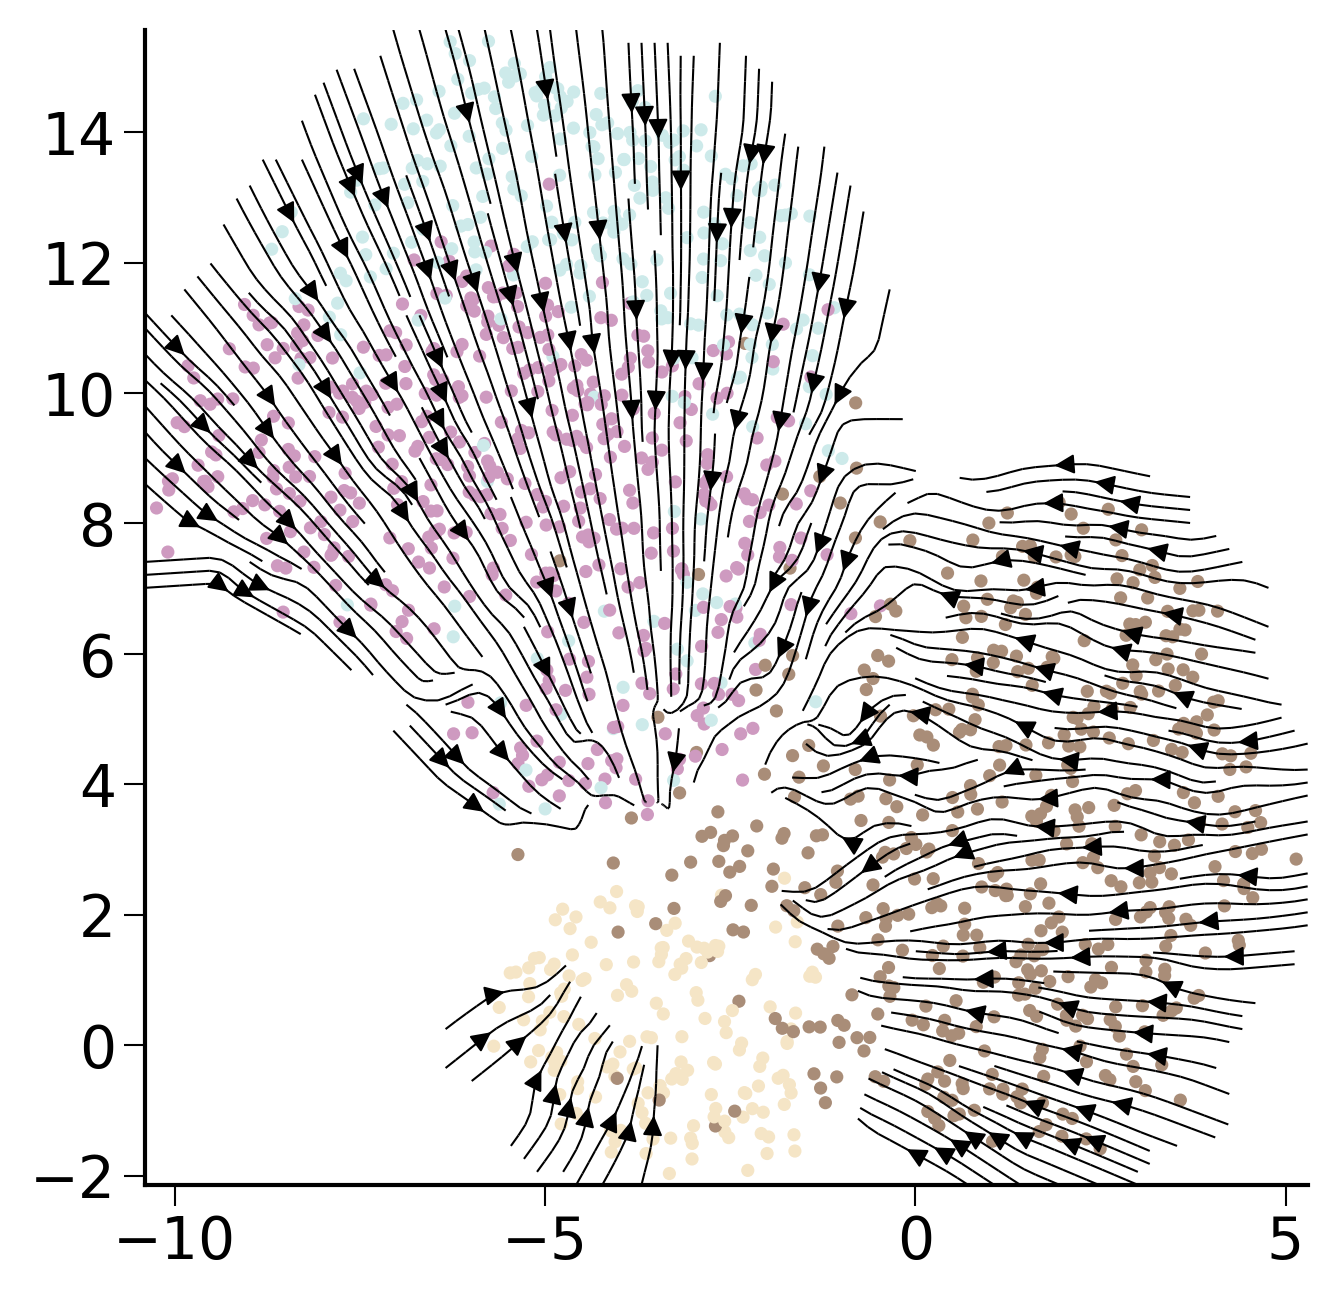

In [18]:
import numpy as np
from scipy.stats import norm as normal
from sklearn.neighbors import NearestNeighbors
import tqdm
sc.pp.neighbors(adata2)

X = adata2.obsm['geneEnc'][:,0,:]
M = adata2.obsm['genemap'][:,0,:]
N = adata2.obsp['connectivities']
E = adata2.obsm["X_umap"]
norm = lambda x: (x-min(x))/(max(x)-min(x))
nn = NearestNeighbors(n_neighbors=20)
nn.fit(X)
dE = []

for i in tqdm.trange(N.shape[0]):
    D,I = nn.kneighbors( np.array([M[i]]) )
    dE.append( (E[I][0] - E[i]).mean(0))
dE = np.vstack(dE)
gE, gdE = compute_velocity_on_grid(E,dE,density=2, adjust_for_stream=True,smooth=True)
fig,ax=createFig(figsize=(5, 5))
fig.set_size_inches(5,5)
palette = sc.pl._tools.scatterplots._get_palette(adata2, 'cell_type')
ax.scatter(E[:,0],E[:,1],s=10, linewidths=0,c=list(map(lambda x: palette[x], adata2.obs['cell_type'])))
stream_kwargs = {
        "linewidth": 0.5,
        "density": 3,
        "zorder": 3,
        "color": "black",
        "arrowsize":  1,
    
        "arrowstyle": "-|>",
        "maxlength":  10,
        "integration_direction":  "both",
}
ax.streamplot(gE[0],gE[1],gdE[0],gdE[1],**stream_kwargs)



In [25]:
dic_true={}
for i in range((adata.shape[0])):
    if(adata.obs['HSC_preference'][i]=='Ly'):
        dic_true[adata.obs['index'][i]]=1
    else:
        dic_true[adata.obs['index'][i]]=0
all_cell1=list(set(list(traincell1)+list(testcell1)))
all_cell2=list(set(list(traincell2)+list(testcell2)))

from torch.utils.data import Dataset, DataLoader
class UndiffDataset(Dataset):
    # 构造器初始化方法
    def __init__(self,length):
        self.length=length

    # 重写getitem方法用于通过idx获取数据内容
    def __getitem__(self, idx):
        i=int(list((all_cell1))[idx])
        gene=adata.X[i].toarray()
        gene=torch.tensor(gene)
        true_fate=dic_true[i]
        #genetype=dic1[genetype]
        true_fate=torch.tensor(true_fate)
        return gene,true_fate

    # 重写len方法获取数据集大小
    def __len__(self):
        return self.length
class otherDataset(Dataset):
    # 构造器初始化方法
    def __init__(self,length):
        self.length=length

    # 重写getitem方法用于通过idx获取数据内容
    def __getitem__(self, idx):
        i=int(list((all_cell2))[idx])
        gene=adata.X[i].toarray()
        gene=torch.tensor(gene)
        genetype=adata.obs['cell_type'][i]
        genetype=dic[genetype]
        genetype=torch.tensor(genetype)
        return gene,genetype

    # 重写len方法获取数据集大小
    def __len__(self):
        return self.length
def dup_rows(a, indx, num_dups=1):
    return np.insert(a,[indx+1]*num_dups,a[indx],axis=0)


unidffdataset = UndiffDataset(len(all_cell1))
otherdataset=otherDataset(len(all_cell2))
Undiffdataloader = DataLoader(unidffdataset, batch_size=len((all_cell1)), num_workers=4, shuffle=False, drop_last=False)
otherdataloader=DataLoader(otherdataset, batch_size=1, num_workers=4, shuffle=False, drop_last=False)

In [26]:
true=0
dic={'HSC':3,'My':0,'Ery':0,'Ly':1}
cudaid = 'cuda:7'
# dic={'Monocyte':0, 'Neutrophil':1, 'Lymphoid':2,'Mast':3, 'Ccr7_DC':4,
#        'Baso':5, 'Eos':6}
device2 = torch.device(cudaid)
geneEnc.to(device2)
model.to(device2)
for i, onebatch1 in enumerate(Undiffdataloader):
    cell1=onebatch1[0].to(device2)
    cell1=geneEnc(cell1)
    hang=cell1.shape[0]
    #cell1=torch.reshape(cell1,(hang,256))
    true_labels=onebatch1[1]
    #print(cell1)
    #print(true_labels)
    pre=torch.zeros(hang)
    pre_labels=torch.zeros((hang,3))
    print(i)
    for j, onebatch2 in enumerate(otherdataloader):
        print(j)
        cell2=onebatch2[0].to(device2)
        cell2=geneEnc(cell2)
        cell2=dup_rows(cell2.cpu().detach().numpy(), indx=0,num_dups=hang-1)
        cell2=torch.tensor(cell2).to(device2)
        genetype=onebatch2[1]
        geneEmbs = torch.cat((cell1, cell2), 2)
        outputs = model(geneEmbs)
        outputs=torch.reshape(outputs,(hang,3))
        #print(outputs)
        outputs=outputs.argmax(-1)
        #print(outputs)
        for num in range(hang):
            if(int(outputs[num])!=2):
                pre_labels[num][int(outputs[num])]+=1
        del outputs,cell2,genetype,geneEmbs
        torch.cuda.empty_cache()
    matrix1=pre_labels
    #print(pre_labels)
    #print(pre_labels)
    pre_labels=np.argsort(-pre_labels)
    #print(pre_labels)
    pre_labels=pre_labels.T[0]
    #print(pre_labels)
    true+=np.count_nonzero(pre_labels==true_labels)
    #np.savetxt('/home/songtao/matrix.txt',matrix1)
    del cell1
    torch.cuda.empty_cache()
     


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


In [27]:
true/len(all_cell1)

0.779874213836478